In [1]:
%load_ext autoreload
%autoreload 2

from zipfile import ZipFile
from matplotlib import pyplot as plt 
from PIL import Image
import numpy as np
import sys
import os

import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms

from keras.layers import Dense, Flatten, Conv2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder

sys.path.insert(1, './../Aula02/')
from src.train import get_all_subsets, results_binary

2023-10-31 08:14:46.829658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-31 08:14:46.829688: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-31 08:14:46.829711: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-31 08:14:46.836434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# !echo 0 | sudo tee -a /sys/bus/pci/devices/0000\:01\:00.0/numa_node

# os.environ['CUDA_VISIBLE_DEVICES'] = "0"
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [3]:
# Avaliar se tem GPU presente e operando no hardware
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [4]:
# Carregando handle para o arquivo zip
source_file = './dataset/brain-cancer.zip'
zip = ZipFile(source_file)

In [5]:
# Função para associar a label do target (yes/no) a cada imagem utilizando o caminho ou nome do arquivo
def get_label(filename):
    parts = filename.lower().split('/')
    result = None
    if 'yes' in parts:
        result = 1
    elif 'no' in parts:
        result = 0
    else:
        pass
    
    return result

assert get_label('brain_tumor_dataset/no/30 no.jpg') == 0
assert get_label('brain_tumor_dataset/NO/31 no.jpg') == 0
assert get_label('yes/Y95.jpg') == 1
assert get_label('brain_tumor_dataset/yes/Y155.JPG') == 1
assert get_label('brain_tumor_dataset/Y155.JPG') == None

# Função para retornar a imagem (array) normalizada 
def get_image_array(filename):
    new_size = (224, 224)
    img_data = Image.open(zip.open(filename))
    img_array = np.array(img_data.resize(new_size), np.int8)
    if img_array.ndim == 1: 
        # Replicar o canal para imagens em escala de cinza
        img_array = np.expand_dims(img_array, axis = -1)
        img_array = np.concatenate([img_array] * 3, axis = -1)

    # normalizar
    img_array_normalized = (img_array - img_array.mean()) / img_array.std()

    return img_array_normalized


In [6]:
"""
processar todos os arquivos do zip para obter:
    * features: imagens
    * labels: yes/None
"""

images = []
labels = []
data_results_dict = []

for filename in zip.namelist():
    
    # label 0 = no, 1 = yes
    label = get_label(filename)

    # Recupera o array da imagem
    img_array = get_image_array(filename) 
    
    # Cria um dicionário com as informações
    data_results_dict.append(
        {'filename': filename, 
         'label': label, 
         'img_array': img_array}
    )

    # Corta imagens fora do padrão
    if img_array.shape == (224, 224, 3):
        # get X and y vars
        images.append(img_array)
        labels.append(label)


In [7]:
# Validação do tamanho dos datasets
len(images), len(labels)

(434, 434)

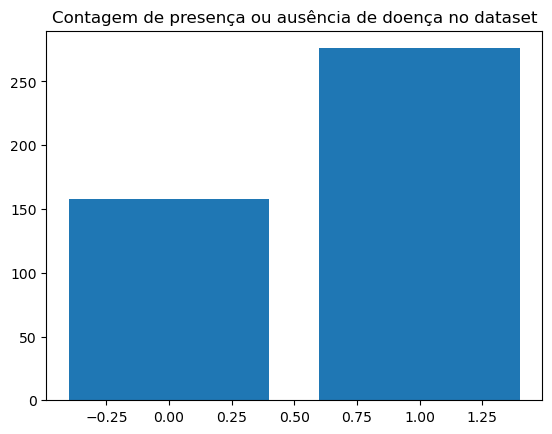

In [8]:
# Contagem de valores para a variável dependente
y_count = np.unique(labels, return_counts=True)

plt.bar(y_count[0], height=y_count[1])
plt.title("Contagem de presença ou ausência de doença no dataset")
plt.show()

In [9]:
# Separando dados de treinamento, validação e teste
X_train, X_val, X_test, y_train, y_val, y_test = get_all_subsets(np.array(images), 
                                                                 np.array(labels))

In [10]:
# Codificando conjunto do target (yes/no) para binário
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1,1)).toarray()

In [11]:
# Mostrando o formato dos sunconjuntos
print("Shape X_train: ", X_train.shape)
print("Shape X_val: ", X_val.shape)
print("Shape X_test: ", X_test.shape)

print("Shape y_train: ", y_train.shape)
print("Shape y_val: ", y_val.shape)
print("Shape y_test: ", y_test.shape)


Shape X_train:  (277, 224, 224, 3)
Shape X_val:  (70, 224, 224, 3)
Shape X_test:  (87, 224, 224, 3)
Shape y_train:  (277, 2)
Shape y_val:  (70, 2)
Shape y_test:  (87, 2)


In [12]:
# Implementação da rede 
# https://stackoverflow.com/questions/44232898/memoryerror-in-tensorflow-and-successful-numa-node-read-from-sysfs-had-negativ

seq_net = Sequential()
seq_net.add(Conv2D(filters=1, \
                        kernel_size=3, \
                        activation='relu', \
                        input_shape=[224,224,3]))

seq_net.add(Flatten())
seq_net.add(Dense(512, activation='relu'))
seq_net.add(Dense(256, activation='relu'))
seq_net.add(Dense(64, activation='relu'))
seq_net.add(Dense(2, activation='softmax'))


2023-10-31 08:14:54.059254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 840 MB memory:  -> device: 0, name: NVIDIA GeForce MX230, pci bus id: 0000:01:00.0, compute capability: 6.1


In [13]:
seq_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 1)       28        
                                                                 
 flatten (Flatten)           (None, 49284)             0         
                                                                 
 dense (Dense)               (None, 512)               25233920  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 25381854 (96.82 MB)
Trainable params: 2538

In [14]:
seq_net.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [15]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, verbose = 1, mode = 'auto')

history = seq_net.fit(X_train, y_train, \
                           epochs=100, \
                            verbose=1, \
                            shuffle=True, \
                            batch_size=1, \
                            validation_data=(X_val, y_val), 
                            callbacks=[es])

Epoch 1/100


2023-10-31 08:14:55.898459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-31 08:14:56.372839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:188] failed to create cublas handle: the resource allocation failed
2023-10-31 08:14:56.372861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:191] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-10-31 08:14:56.373286: W tensorflow/core/kernels/conv_ops_gpu.cc:144] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 1
in_depths: 3
out_depths: 1
in: 224
in: 224
data_format: 1
filter: 3
filter: 3
filter: 3
dilation: 1
dilation: 1
stride: 1
stride: 1
padding: 0
padding: 0
dtype: DT_FLOAT
group

NotFoundError: Graph execution error:

Detected at node sequential/conv2d/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 724, in start

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 501, in process_one

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 731, in execute_request

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 417, in do_execute

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code

  File "/tmp/ipykernel_27912/2776001978.py", line 3, in <module>

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/pablo_veinberg/.local/lib/python3.10/site-packages/keras/src/backend.py", line 5397, in relu

No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng11{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(6629): 'status'
  Profiling failure on CUDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(6629): 'status'
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_train_function_1322]

In [ ]:
y_pred = rede_simples.predict(X_test)

3/3 [==============================] - 0s 67ms/step


In [ ]:
results_binary(y_test.argmax(1), y_pred.argmax(1))
print('-- end')

Confusion Matrix :
[[34  3]
 [ 1 49]]
Report : 
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.94      0.98      0.96        50

    accuracy                           0.95        87
   macro avg       0.96      0.95      0.95        87
weighted avg       0.95      0.95      0.95        87

Accuracy: 95.40%
-- end


: 

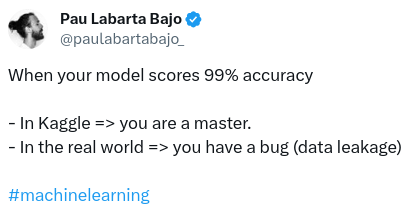

In [ ]:
y_pred[:10], y_test[:10]


(array([[0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994],
        [0.99999994]], dtype=float32),
 array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1]))

In [ ]:
y_pred

array([[0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [0.999